# Data Stack Preparation (data-prep)

This tutorial will walk you through the workflow of the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo. At the end of this tutorial, you will create multi-band geotiffs that can be used for the identification and classification of specific agroforestry systems, such as palm-oil plantations.

## 1) Get credentials ##
This repo makes use of several third-party services which will require credentials. These can be obtained using the following links. Please note that approval of an account may take several days in some cases.

1) [NASA Earthdata](https://urs.earthdata.nasa.gov/users/new)

2) [JAXA](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/registration.htm)

3) [AWS S3/EC2](https://portal.aws.amazon.com/billing/signup#/start) or [Google Cloud Storage/GCS](https://cloud.google.com/storage/), if using cloud storage is desired

4) [Google Earth Engine](https://earthengine.google.com/)

One-time authentication for Google Earth Engine:

In [1]:
import ee
ee.Authenticate()

Enter verification code: xxxxxx
Successfully saved authorization token.


## 2) Set up data-prep conda environment ##

To create the **data-prep** environment and install required packages, run these commands in your terminal:

```
% cd data-prep
% conda env create -f data-prep-env.yml
% conda activate data-prep
```

Run **setup.py** to verify environment and permissions of scripts:

In [1]:
%run setup.py

ALOS-2/alos2_download_mosaic.py
ALOS-2/alos2_proc.py
Landsat/gee_export_landsat_ndvi.py
MODIS/gee_export_modis_tc.py
Sentinel/s1_build_vrt.py
Sentinel/s1_metadata_summary.py
Sentinel/s1_proc.py
Sentinel/s1_remove_edges.py
Sentinel/s1_submit_hyp3_jobs.py
Stacks/build_stacks.py
Stacks/build_condensed_stacks.py
Utils/calc_vrt_stats.py
Utils/prep_tiles.py
Utils/remove_edges.py


## 3) Set up project directory ##

This repo will make use of one consistent project directory, referred from here as `proj_dir`. The name of `proj_dir` is up to you, but all subfolders and completed tiles will be generated automatically. The completed stacks as well as any intermediate products will be stored in `proj_dir`. At the moment, AWS S3, GCS, and local storage systems are supported. Some extra setup may be required, depending on your storage system of choice:

* To set up AWS Command Line Interface (CLI) configurations and credentials (required if your `proj_dir` is S3):

    ```
    (data-prep) % aws configure
    ```

    where you will be asked to enter your **aws_access_key_id** and **aws_secret_access_key**.
    
    If using S3, then `proj_dir` should be `s3://your_bucket/some_prefix` when used as an argument to scripts.


* To set up Google Cloud gsutil tool (required if your `proj_dir` is GCS):

    ```
    (data-prep) % gsutil config
    ```

    Then you will be prompted to sign in using your Google credentials.
    
    If using GCS, then `proj_dir` should be `gs://your_bucket/some_prefix` when used as an argument to scripts.
    
    
* If using local storage, create a new folder at the desired location in your filesystem. Note that using local storage is not advised as the stacks generated will be large files, and some steps will be faster if run in the cloud. If using local storage, then `proj_dir` should be `your_local_path` when passed as an argument to scripts. Note that `your_local_path` must point to a directory that exists--it will not be automatically generated for you.

## 4) Prepare UTM tiles for Area of Interest (AOI) ##

To create the stacks, a universal tiling system is required to ensure all data sources are aligned to the same grid. In the following section, we will generate a geoJSON file that contains the tiles to be used by all of the data processing scripts.

### prep_tiles.py ###

prep.tiles.py will create the tile geoJSON. It takes three required arguments: aoi_name, aoi_shp, and tile_size. aoi_name is used to name the output geojson. aoi_shp should point to a shapefile or geoJSON of the area of interest. geoJSON files for many subnational administrative boundaries can be found here: (insert link) tile_size is the desired size of each tile, in meters.

### Usage ###

```
(data-prep) % python prep_tiles.py [-h] aoi_name aoi_shp tile_size
```

In [7]:
import geopandas as gp
import contextily as cx

def plot(shape_file, fill_outline, fig_size):
    df = gp.read_file(shape_file[0])
    df = df.to_crs(epsg=3857)
    ax = None
    for i in range(0, len(shape_file)):
            df = gp.read_file(shape_file[i])
            df = df.to_crs(epsg=3857)
            if(fill_outline[i]):
                ax = df.plot(ax=ax, figsize=fig_size)
            else:
                ax = df.exterior.plot(ax=ax, figsize=fig_size)
    cx.add_basemap(ax, url='http://a.tile.openstreetmap.org/tileZ/tileX/tileY.png')

Suppose our area of interest is the Ucayali region of Peru, highlighted in blue:

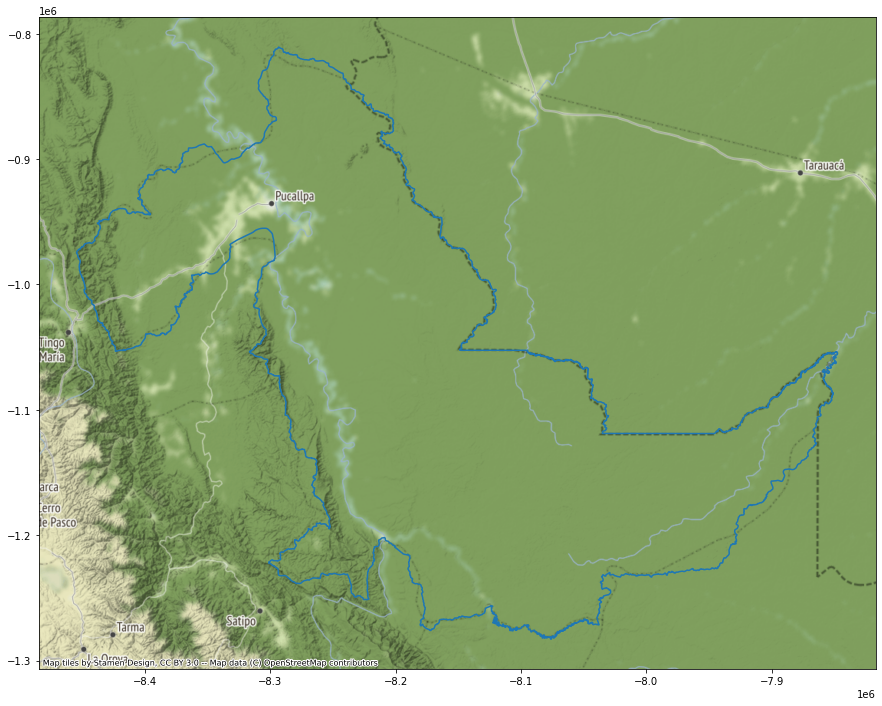

In [4]:
fill = True
outline = False
plot(["AOI/ucayali/ucayali_boundary.geojson"], [outline], (15, 15))

Create tiles for our AOI with a tile size of 150x150 km:

In [9]:
%run Utils/prep_tiles.py AOI/ucayali/ucayali AOI/ucayali/ucayali_boundary.geojson 150000

Tiles for Aoi/ucayali/ucayali: aoi/ucayali/ucayali_tiles.geojson
14 out of 20 tiles intersecting Aoi/ucayali/ucayali


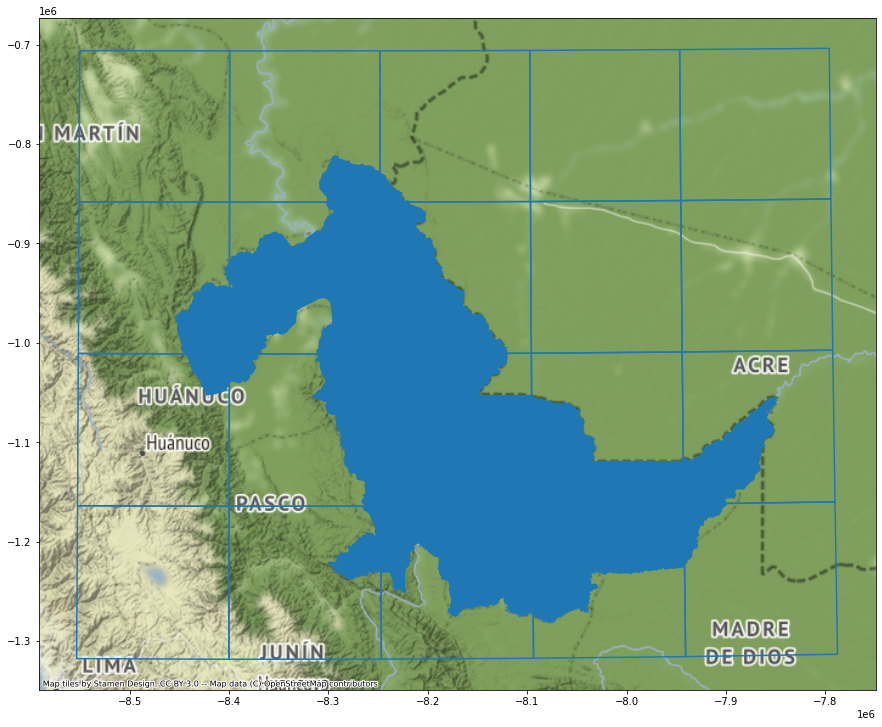

In [5]:
fill = True
outline = False
plot(["AOI/ucayali/ucayali_boundary.geojson", "AOI/ucayali/ucayali_tiles.geojson"], [fill, outline], (15, 15))

Note that some tiles do not intersect the region. These will be masked out and will not be used for the final stacks.

## 5) Prepare Sentinel-1 Tiles ##

The first piece of the data stack is Sentinel-1 tiles. In the following section, we search for granules within our AOI, process them using the ASF HyP3 API, and calculate statistics for the granules, saving the results as .tif files in the sentinel_1 subdirectory under proj_dir.

## Search for Sentinel-1 granules on [ASF Vertex](https://search.asf.alaska.edu/#/) ##

1. Sign in using your Earthdata credentials, which were obtained in section 1. If you haven't used ASF Vertex before, you will need to agree their terms in order to use their HyP3 processing.

2. Use the following "Additional Filters" when searching for granules within your AOI:

    * File Type: L1 Detected High-Res Dual-Pol (GRD-HD)
    * Beam Mode: IW
    * Polarization: VV+VH

    ![vertex_search_filters](img/vertex_search_filters.png)

3. Add the selected granules into the download queue:

    ![vertex_add_queue](img/vertex_add_queue.png)

4. Download metadata files. Download at least one csv or geojson file, which will be used for submitting HyP3 jobs.

    ![vertex_download_metadata](img/vertex_download_metadata.png)

5. Clear the selected granules in the downloads. Do not download these GRD-HD products as we will submit HyP3 jobs to apply radiometric terrain correction (RTC) to them.

## Submit HyP3 RTC jobs ##

For the initial processing of the Sentinel-1 granules, we make use of ASF's HyP3 API. Information about the specifics of this processing can be found in the [HyP3 documentation](https://hyp3-docs.asf.alaska.edu/).

### s1_submit_hyp3_jobs.py ###

`s1_submit_hyp3_jobs.py` will submit the granules chosen in the previous step to the HyP3 API for processing. The results can either be saved locally or uploaded to cloud storage, such as AWS S3 or Google Cloud Storage (GCS). It takes two arguments: `proj_dir`, and `csv/geojson`. `proj_dir` should point to your project directory (see section 3).
`csv/geojson` should point to the location of the metadata files containing a list of granules to be submitted for processing downloaded in the previous step. The processed granules will be saved in the following directory structure:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

### Notes ###

* Since ASF HyP3 stores the processed granules in their AWS S3 buckets, the data transfer will be much faster if you use an AWS S3 bucket for `proj_dir`.
* This script will require your Earthdata credentials, which can be obtained in section 1.


    
### Usage ###

```
(data-prep) % python s1_submit_hyp3_jobs.py [-h] proj_dir csv/geojson
```

Submit Sentinel-1 granules from the Ucayali region in the year 2017 for processing:

In [ ]:
%run Sentinel/s1_submit_hyp3_jobs.py Sentinel/granules/ucayali/ucayali_sentinel_granules_2017.geojson

## Sentinel-1 Processing ##

The final processing step involves calculating the temporal mean for the Sentinel-1 granules and removing left/right (cross-track) edge pixels where border noise is prominent. 

### s1_proc.py ###

s1_proc.py handles this final processing step. It achieves this using helper scripts in the Sentinel directory: **s1_build_vrt.py** and **calc_vrt_stats.py** for the temporal mean, and **remove_edges.py** for removing edge pixels. It takes 5 arguments: path_frame, m1, and m2 (all optional), proj_dir, and year (both required). If path_frame is specified, only granules matching path_frame will be processed; otherwise, all path_frames under srcpath/year will be processed. If m1 and m2 are specified, only granules with acquisition month >= m1 and <= m2 will be processed. proj_dir refers to the project directory. year is the year of granules to be processed.

|Arguments||Description||Required||Default|
|----||----||----||----|
|path_frame||path_frame of granules to be processed||No||all path_frames under srcpath/year will be processed|
|m1||granules with acquisition month >= m1 will be included in VRT||No||None|
|m2||granules with acquisition month <= m2 will be included in VRT||No||None|
|proj_dir||project directory||Yes||None|
|year||year of Sentinel-1 dataset||Yes||None|

### Notes ###

* The processing will be slow if srcpath is on AWS S3 or GCS because it requires heavy network I/O between the cloud and your local machine. If srcpath is on AWS S3, it is strongly recommended that you run the processing on AWS EC2.

### Usage ###

```
(data-prep) % python s1_proc.py [-h] [--pf path_frame] [--m1 m1] [--m2 m2] proj_dir year
```

Process all granules stored locally for the year 2017:

In [ ]:
%run Sentinel/s1_proc.py . 2017

## 6) Prepare ALOS-2 tiles ##

The next step of the data stack is ALOS-2 tiles. This involves downloading the ALOS-2 mosaic and processing them using an Enhanced Lee filter, storing the results in the alos2_mosaic subdirectory under proj_dir.

## Download ALOS/ALOS-2 Mosaic ##
First, the ALOS-2 mosaic must be downloaded from the JAXA servers. This is accomplished via `alos2_download_mosaic.py`.

### alos2_download_mosaic.py ###
This script takes three arguments: `proj_dir`, `aoi`, and `year`. `proj_dir` refers to your project_directory (see section 3). `aoi` should point to a shapefile or geojson containing your area of interest (see section 4). `year` is the year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019). The results will be stored in the following directory structure:

```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──tarfiles
```
### Notes ###

* Downloading ALOS/ALOS-2 Mosaic data requires a JAXA account, which can be obtained in section 1.

### Usage ###
```
(data-prep) % alos2_download_mosaic.py [-h] proj_dir aoi year
```

In [ ]:
%run ALOS-2/alos2_download_mosaic.py <bucket> <aoi> <year>

## ALOS-2 Processing ##
Next, the ALOS-2 mosaic is processed using an Enhanced Lee filter via `alos2_proc.py`. This will produce three .tif images for each tile: HV, HH, and INC, referring to the different polarizations of the ALOS-2 sensing instrument.

### alos2_proc.py ###
This script takes three arguments: `proj_dir`, `aoi`, and `year`. All three arguments should be the same used in the previous step. Results will be stored in the following directory structure:
```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──<tile name>
```

### Usage ###

```
(data-prep) % alos2_proc.py [-h] proj_dir aoi year
```

In [ ]:
%run ALOS-2/alos2_proc.py <bucket> <aoi> <year>

## 7) Prepare Landsat Tiles ##

The next step is Landsat Tiles. This involves downloading the Landsat data and processing them, by masking clouds and extracting the median, to compute the NDVI (Normalized Difference Vegetation Index). The results will be exported to your Google Drive. 

## Export Landsat NDVI ##
Submit GEE Processing for Landsat NDVI.

### gee_export_landsat_ndvi.py ###
This script takes four arguments: `sitename`, `tiles`, `res`, and `year`. The `sitename` specified will be used to provide a description when exporting the landsat ndvi. `tiles` refers to a shp/geojson file that contains the tiles onto which the landsat ndvi will be resampled, using bilinear interpolation. `res` and `year` refer to the resolution desired when resampling and year you wish to download the landsat ndvi data for, respectively.

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||name of site. used to provide a description when exporting the landsat ndvi||Yes||None|
|tiles||shp/geojson file that contains the tiles onto which the landsat ndvi will be resampled, using bilinear interpolation||Yes||None|
|res||resolution||Yes||None|
|year||year of Landsat ndvi dataset||Yes||None|

### Usage ###

```
(data-prep) % gee_export_landsat_ndvi.py [-h] sitename tiles res year
```

In [ ]:
# sample run here

## 8) Prepare MODIS Tree Cover Tiles ##
The next step is MODIS Tree Cover Tiles. This involves downloading and processing the MODIS data and extracting the Percent Tree Cover. The results will be exported to your Google Drive.


## Export MODIS TC ##
Submit GEE processing for MODIS tree cover. 

### gee_export_modis_tc.py ###
This script takes four arguments: `sitename`, `tiles`, `res`, and `year`. The `sitename` specified will be used to provide a description when exporting the MODIS Tree Cover. `tiles` refers to a shp/geojson file that contains the tiles onto which the MODIS data will be resampled. `res` and `year` refer to the resolution desired when resampling and year you wish to download the MODIS data for, respectively.

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||name of site. used to provide a description when exporting the MODIS Tree Cover||Yes||None|
|tiles||shp/geojson file that contains the tiles onto which the MODIS data will be resampled||Yes||None|
|res||resolution||Yes||None|
|year||year of MODIS dataset||Yes||None|


### Usage ###

```
(data-prep) % gee_export_modis_tc.py [-h] sitename tiles res year
```

In [ ]:
# sample run here

## 9) Build Stacks ##

### build_stacks.py ###

### Usage ###

```
(data-prep) % build_stacks.py [-h] [--sitename sitename] proj_dir tiles year
```

### Description ###

Build 8 band stacks that include (C-VV / C-VH / C-INC / L-HH / L-HV / L-INC / NDVI / TC)
   
### Positional Arguments ###

  **proj_dir**
   
      project directory (s3:// or gs:// or local dirs)
  
  **tiles**
  
      shp/geojson file that contains tiles for the output stacks
      
  **year** 
  
      Year
      
###  Optional Arguements ###
      
  **sitename**
  
      sitename. If sitename not specified, proj_dir basename is used at sitename. 
  
### Notes ###

* ...

In [ ]:
# sample run here